In [92]:
import os
import math
import re
import pandas as pd
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from feature_engine.outliers import Winsorizer
from fast_ml.model_development import train_valid_test_split


from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [2]:
data_path = os.path.join("dataset", "loan_data_2007_2014.csv")
loan_df = pd.read_csv(data_path, low_memory=False, index_col=0)

In [3]:
# drop columns that filled with all NaN values
loan_df = loan_df.dropna(axis = 1, how = "all")
# drop duplicated data
loan_df = loan_df.drop_duplicates()
loan_df.shape

(466285, 57)

In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [5]:
loan_df = loan_df.drop(["id", "member_id"], axis=1)

In [6]:
check_missing = loan_df.isnull().sum() * 100 / loan_df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

mths_since_last_record         86.566585
mths_since_last_major_derog    78.773926
desc                           72.981546
mths_since_last_delinq         53.690554
next_pymnt_d                   48.728567
total_rev_hi_lim               15.071469
tot_cur_bal                    15.071469
tot_coll_amt                   15.071469
emp_title                       5.916553
emp_length                      4.505399
last_pymnt_d                    0.080637
revol_util                      0.072917
collections_12_mths_ex_med      0.031097
last_credit_pull_d              0.009007
inq_last_6mths                  0.006219
open_acc                        0.006219
total_acc                       0.006219
earliest_cr_line                0.006219
delinq_2yrs                     0.006219
acc_now_delinq                  0.006219
pub_rec                         0.006219
title                           0.004289
annual_inc                      0.000858
dtype: float64

In [7]:
col_names = check_missing[check_missing < 75].index.tolist()
for i in loan_df[col_names] :
    print(f"{i} : {loan_df[i].unique()}")

loan_amnt : [ 5000  2500  2400 ... 33675 27775 33175]
funded_amnt : [ 5000  2500  2400 ... 27775 33175 31725]
funded_amnt_inv : [ 4975.  2500.  2400. ... 30425. 33125. 33625.]
term : [' 36 months' ' 60 months']
int_rate : [10.65 15.27 15.96 13.49 12.69  7.9  18.64 21.28 14.65  9.91 16.29  6.03
 11.71 12.42 14.27 16.77  7.51  8.9  18.25  6.62 19.91 17.27 17.58 21.67
 19.42 22.06 20.89 20.3  23.91 19.03 23.52 23.13 22.74 22.35 24.11  6.
 22.11  7.49 11.99  5.99 10.99  9.99 18.79 11.49  8.49 15.99 16.49  6.99
 12.99 15.23 14.79  5.42 10.59 17.49 15.62 21.36 19.29 13.99 18.39 16.89
 17.99 20.62 20.99 22.85 19.69 20.25 23.22 21.74 22.48 23.59 12.62 18.07
 11.63  7.91  7.42 11.14 20.2  12.12 19.39 16.11 17.54 22.64 13.84 16.59
 17.19 12.87 20.69  9.67 21.82 19.79 18.49 22.94 24.59 24.4  21.48 14.82
 14.17  7.29 17.88 20.11 16.02 17.51 13.43 14.91 13.06 15.28 15.65 17.14
 11.11 10.37 16.4   7.66 10.   18.62 10.74  5.79  6.92  9.63 14.54 12.68
 19.36 13.8  18.99 21.59 20.85 21.22 19.74 20.48  

In [8]:
drop_cols = check_missing[check_missing >= 75].index.tolist() + [
                                                                "sub_grade",
                                                                "emp_title",
                                                                "url",
                                                                "desc",
                                                                "title",
                                                                "zip_code",
                                                                "policy_code",
                                                                "application_type",
                                                                "funded_amnt_inv",
                                                                "out_prncp_inv",
                                                                "total_pymnt_inv",
                                                                "total_pymnt_inv",
                                                                "addr_state"
                                                            ]
loan_df = loan_df.drop(drop_cols, axis=1)

In [9]:
loan_df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,...,0.00,Jan-15,171.62,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
1,2500,2500,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,...,1.11,Apr-13,119.66,NaN,Sep-13,0.0,0.0,NaN,NaN,NaN
2,2400,2400,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,...,0.00,Jun-14,649.91,NaN,Jan-16,0.0,0.0,NaN,NaN,NaN
3,10000,10000,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,...,0.00,Jan-15,357.48,NaN,Jan-15,0.0,0.0,NaN,NaN,NaN
4,3000,3000,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,...,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,0.0,NaN,NaN,NaN


### Define target

In [10]:
loan_df['loan_status'].value_counts(normalize=True)*100

Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: loan_status, dtype: float64

In [11]:
loan_df['loan_status'].isnull().sum()/len(loan_df)*100

0.0

In [12]:
loan_df['loan_status'] = loan_df['loan_status'].replace(
    {'Fully Paid':'excellent',
    'Current':'good',
    'In Grace Period':'good',
    'Late (16-30 days)':'fair',
    'Late (31-120 days)':'fair',
    'Charged Off': 'bad',
    'Default':'bad',
    'Does not meet the credit policy. Status:Charged Off':'bad',
    'Does not meet the credit policy. Status:Fully Paid':'bad'
})

In [13]:

loan_df['loan_status'].value_counts(normalize=True)*100

good         48.762452
excellent    39.619332
bad           9.877221
fair          1.740995
Name: loan_status, dtype: float64

### emp_length

In [14]:
loan_df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [15]:
loan_df['emp_length_int'] = loan_df['emp_length'].str.replace(r"\+ years|\ years|\ year", '', regex=True)
loan_df['emp_length_int'] = loan_df['emp_length_int'].str.replace('< 1', str(0))
loan_df['emp_length_int'] = loan_df['emp_length_int'].astype(float)

In [16]:
loan_df = loan_df.drop(["emp_length"], axis=1)

### term

In [17]:
loan_df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [18]:
loan_df['term'] = loan_df['term'].str.replace('\ months', '')
loan_df['term'] = loan_df['term'].str.replace(' ', '')

In [19]:
loan_df['term'].unique()

array(['36', '60'], dtype=object)

### earliest_cr_line

In [20]:
loan_df['earliest_cr_line'].head(3)

0    Jan-85
1    Apr-99
2    Nov-01
Name: earliest_cr_line, dtype: object

In [21]:
loan_df['earliest_cr_line_date'] = pd.to_datetime(loan_df['earliest_cr_line'], format='%b-%y')
loan_df['earliest_cr_line_date'].head(3)

0   1985-01-01
1   1999-04-01
2   2001-11-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

In [22]:
loan_df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
loan_df['mths_since_earliest_cr_line'].head(3)

0    395.0
1    224.0
2    193.0
Name: mths_since_earliest_cr_line, dtype: float64

In [23]:
loan_df['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [24]:
loan_df[loan_df['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(2)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0


In [25]:
loan_df.loc[loan_df['mths_since_earliest_cr_line']<0, 'mths_since_earliest_cr_line'] = loan_df['mths_since_earliest_cr_line'].max()

In [26]:
loan_df = loan_df.drop(['earliest_cr_line', 'earliest_cr_line_date'], axis=1)

### issue_d

In [27]:
loan_df['issue_d_date'] = pd.to_datetime(loan_df['issue_d'], format='%b-%y')
loan_df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['issue_d_date']) / np.timedelta64(1, 'M')))

In [28]:
loan_df['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

In [29]:
loan_df = loan_df.drop(['issue_d', 'issue_d_date'], axis=1)

### last_pymnt_d

In [30]:
loan_df['last_pymnt_d_date'] = pd.to_datetime(loan_df['last_pymnt_d'], format='%b-%y')
loan_df['mths_since_last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['last_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [31]:
loan_df['mths_since_last_pymnt_d'].describe()

count    465909.000000
mean         31.294369
std          12.809898
min          23.000000
25%          23.000000
50%          24.000000
75%          35.000000
max         120.000000
Name: mths_since_last_pymnt_d, dtype: float64

In [32]:
loan_df = loan_df.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1)

### next_pymnt_d

In [33]:
loan_df['next_pymnt_d_date'] = pd.to_datetime(loan_df['next_pymnt_d'], format='%b-%y')
loan_df['mths_since_next_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['next_pymnt_d_date']) / np.timedelta64(1, 'M')))

In [34]:
loan_df['mths_since_next_pymnt_d'].describe()

count    239071.000000
mean         22.738136
std           6.082298
min          21.000000
25%          22.000000
50%          22.000000
75%          22.000000
max         120.000000
Name: mths_since_next_pymnt_d, dtype: float64

In [35]:
loan_df = loan_df.drop(['next_pymnt_d', 'next_pymnt_d_date'], axis=1)

### last_credit_pull_d

In [36]:
loan_df['last_credit_pull_d_date'] = pd.to_datetime(loan_df['last_credit_pull_d'], format='%b-%y')
loan_df['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_df['last_credit_pull_d_date']) / np.timedelta64(1, 'M')))

In [37]:
loan_df['mths_since_last_credit_pull_d'].describe()

count    466243.000000
mean         27.045588
std           9.636423
min          23.000000
25%          23.000000
50%          23.000000
75%          25.000000
max         127.000000
Name: mths_since_last_credit_pull_d, dtype: float64

In [38]:
loan_df = loan_df.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1)

### home_ownership

In [39]:
loan_df["home_ownership"].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [40]:
loan_df["home_ownership"] = loan_df["home_ownership"].replace({
    'OTHER' : 'ANY'
})

In [41]:
loan_df["home_ownership"].value_counts(normalize=True)*100

MORTGAGE    50.586015
RENT        40.420129
OWN          8.943886
ANY          0.039246
NONE         0.010723
Name: home_ownership, dtype: float64

## Data Visualization

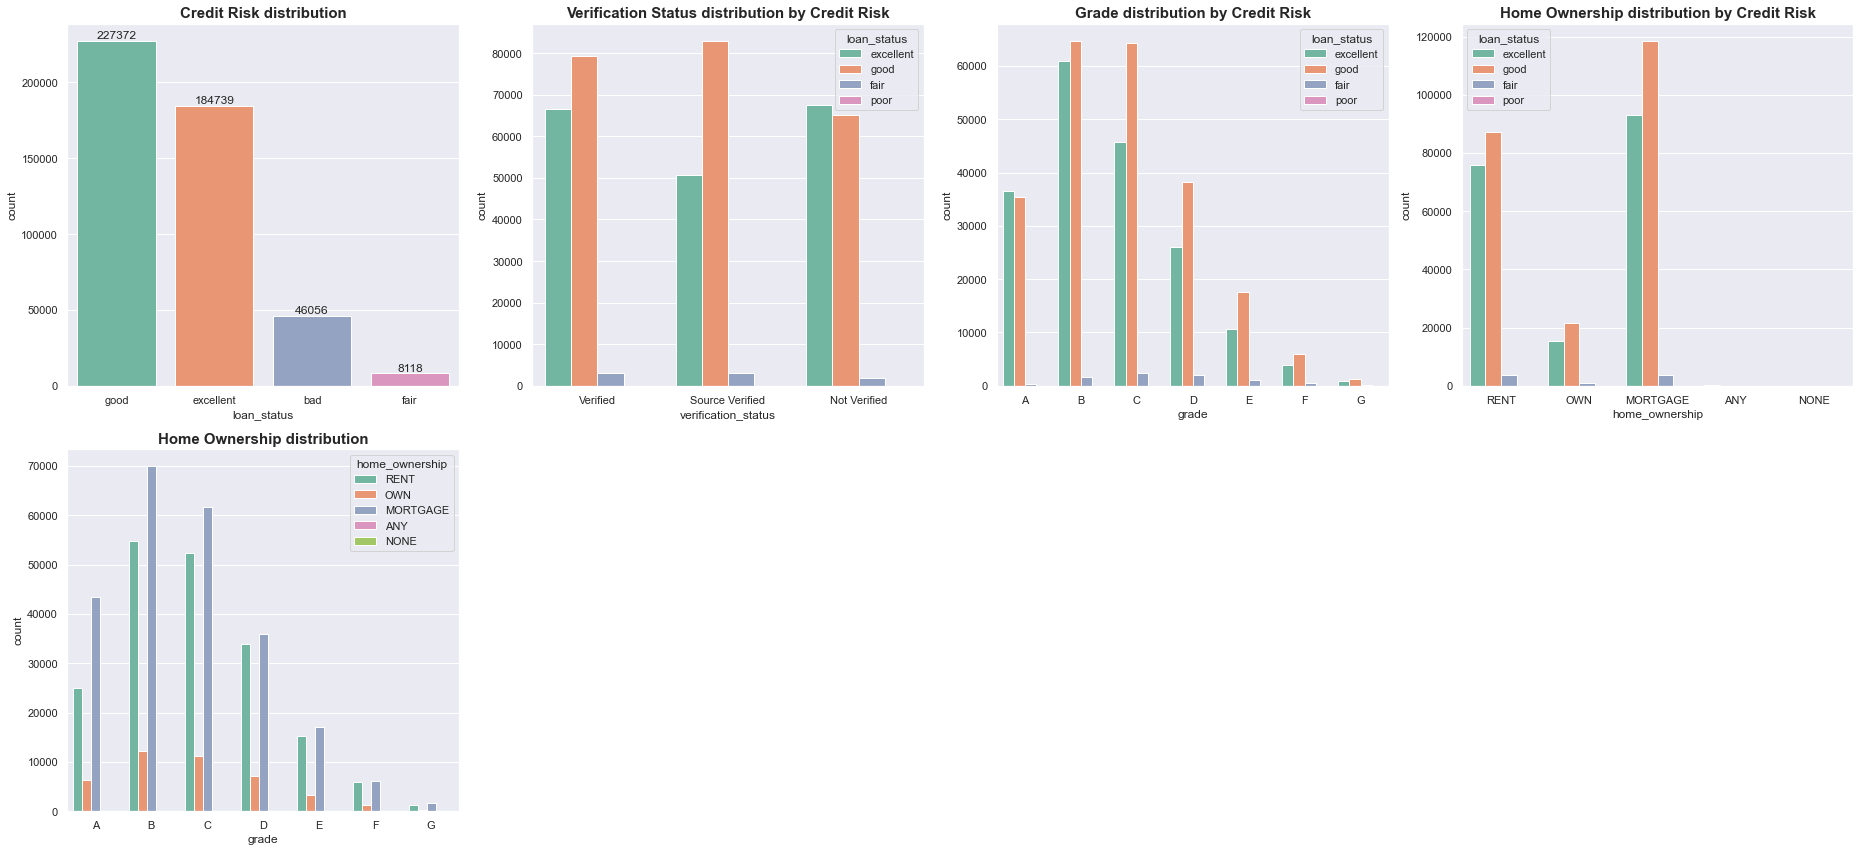

In [42]:
plt.figure(figsize=(26, 12))
plt.subplot(241)
abs_values = loan_df["loan_status"].value_counts(ascending=False).values
ax = sns.countplot(
    x= "loan_status",
    data= loan_df,
    order=loan_df["loan_status"].value_counts().index,
    palette='Set2'
)
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.title("Credit Risk distribution",
    loc="center",
    fontweight="bold",
    size=15
)

plt.subplot(242)
sns.countplot(
    x= "verification_status",
    data= loan_df,
    hue = "loan_status",
    hue_order=["excellent", "good", "fair", "poor"],
    palette='Set2'
)
plt.title("Verification Status distribution by Credit Risk",
    loc="center",
    fontweight="bold",
    size=15
)

plt.subplot(243)
sns.countplot(
    x= "grade",
    data= loan_df,
    hue = "loan_status",
    order=["A", "B", "C", "D", "E", "F", "G"],
    hue_order=["excellent", "good", "fair", "poor"],
    palette='Set2'
)
plt.title("Grade distribution by Credit Risk",
    loc="center",
    fontweight="bold",
    size=15
)

plt.subplot(244)
sns.countplot(
    x= "home_ownership",
    hue = "loan_status",
    data= loan_df,
    hue_order=["excellent", "good", "fair", "poor"],
    palette='Set2'
)
plt.title("Home Ownership distribution by Credit Risk",
    loc="center",
    fontweight="bold",
    size=15
)

plt.subplot(245)
sns.countplot(
    x= "grade",
    hue = "home_ownership",
    data= loan_df,
    order=["A", "B", "C", "D", "E", "F", "G"],
    palette='Set2'
)
plt.title("Home Ownership distribution",
    loc="center",
    fontweight="bold",
    size=15
)
plt.tight_layout()
plt.show()

In [43]:
model_data = loan_df.copy()

### Encode Target

In [44]:
model_data["risk_flag"] = loan_df['loan_status'].replace(
    {'excellent' : 3,
    'good' : 2,
    'fair' : 1,
    'bad' : 0,
})

In [45]:
model_data.drop(["loan_status"], axis=1, inplace=True)

### Data Split

In [46]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(model_data, target = "risk_flag", 
                                                                            train_size=0.7, valid_size=0.2, test_size=0.1, random_state=42)

## Outlier Handling

In [47]:
num_col = [col for col in model_data.columns.tolist() if col not in X_train.select_dtypes(include='object').columns.tolist() + ['risk_flag']]

In [48]:
def skewness(data) :
    skew = []
    for i in num_col:
        skew.append(data[i].skew())
    return skew

def outlier_ratio(data, data_info) :
    ratio = []
    for i in range(len(data_info)) :
        feature = data_info["feature"][i]
        if abs(data_info["skewness"][i]) <= 0.5 :
            LL, UL = limit_normal(data[feature])
            try : 
                result = data[feature][(data[feature] <= LL) | (data[feature] >= UL)].count() / len(data[feature])
            except : 
                result = 0
        else : 
            LL, UL = limit_skewed(data[feature])
            try : 
                result = data[feature][(data[feature] <= LL) | (data[feature] >= UL)].count() / len(data[feature])
            except : 
                result = 0
        ratio.append(round(result,6))
    return ratio

def limit_normal(data) :
    lower_limit = data.mean() - (3 * data.std())
    upper_limit = data.mean() + (3 * data.std())
    return lower_limit, upper_limit

def limit_skewed(data) : 
    Q1, Q3 = np.quantile(data, (0.25, 0.75))
    IQR = Q3 - Q1
    lower_limit = Q1 - (IQR * 1.5)
    upper_limit = Q3 + (IQR * 1.5)
    return lower_limit, upper_limit


In [49]:
outliers_info = pd.DataFrame({
    "feature" : num_col,
    "skewness" : skewness(X_train)
})

In [50]:
outliers_info["ratio"] = outlier_ratio(X_train, outliers_info)

In [51]:
outliers_info

,feature,skewness,ratio
0,loan_amnt,0.732180,0.000000
1,funded_amnt,0.736164,0.000000
2,int_rate,0.333068,0.000000
3,installment,0.950146,0.025098
4,annual_inc,23.687594,0.000000
5,dti,0.186466,0.000000
6,delinq_2yrs,5.388407,0.000000
7,inq_last_6mths,2.189453,0.000000
8,mths_since_last_delinq,0.464947,0.000181
9,open_acc,1.174305,0.000000


In [52]:
# for normal distribution
normal_cap = Winsorizer(
    capping_method='gaussian',
    tail='both',
    fold=1.5,
    variables=outliers_info[(abs(outliers_info['skewness']) <= 0.5) & (outliers_info['ratio'] < 0.15)]['feature'].tolist(),
    missing_values='ignore'
)

# for skewed distribution
skewed_cap = Winsorizer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables=outliers_info[~(abs(outliers_info['skewness']) <= 0.5) & (outliers_info['ratio'] < 0.15)]['feature'].tolist(),
    missing_values='ignore'
)

In [53]:
X_train = normal_cap.fit_transform(X_train)
X_train = skewed_cap.fit_transform(X_train)

In [54]:
outliers_info["result"] = skewness(X_train)
outliers_info

,feature,skewness,ratio,result
0,loan_amnt,0.732180,0.000000,0.732180
1,funded_amnt,0.736164,0.000000,0.736164
2,int_rate,0.333068,0.000000,0.056408
3,installment,0.950146,0.025098,0.740361
4,annual_inc,23.687594,0.000000,0.881806
5,dti,0.186466,0.000000,0.068949
6,delinq_2yrs,5.388407,0.000000,0.000000
7,inq_last_6mths,2.189453,0.000000,0.790370
8,mths_since_last_delinq,0.464947,0.000181,0.258201
9,open_acc,1.174305,0.000000,0.659795


## Missing Value

### Numerical

In [55]:
check_missing = X_train.select_dtypes(exclude='object').isnull().sum() * 100 / X_train.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

mths_since_last_delinq           53.646304
mths_since_next_pymnt_d          48.699291
tot_cur_bal                      15.069899
total_rev_hi_lim                 15.069899
tot_coll_amt                     15.069899
emp_length_int                    4.498482
mths_since_last_pymnt_d           0.079963
revol_util                        0.073530
collections_12_mths_ex_med        0.032476
mths_since_last_credit_pull_d     0.009191
mths_since_earliest_cr_line       0.006434
acc_now_delinq                    0.006434
delinq_2yrs                       0.006434
total_acc                         0.006434
pub_rec                           0.006434
open_acc                          0.006434
inq_last_6mths                    0.006434
annual_inc                        0.000613
dtype: float64

In [56]:
X_train_join = pd.concat([X_train, y_train], axis = 1)

In [57]:
X_train_join

,loan_amnt,funded_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,pymnt_plan,...,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,emp_length_int,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_next_pymnt_d,mths_since_last_credit_pull_d,risk_flag
368118,15000.0,15000.0,36,11.670000,495.86,B,MORTGAGE,57000.0,Not Verified,n,...,0.0,209908.0,43300.0,10.00000,171.0,42.0,35.0,NaN,23.0,0
249237,11000.0,11000.0,60,19.990000,291.38,E,RENT,30000.0,Source Verified,n,...,0.0,60381.0,28000.0,2.00000,100.0,37.0,24.0,22.0,23.0,2
181464,25000.0,25000.0,36,14.330000,858.46,C,MORTGAGE,86000.0,Verified,n,...,0.0,116252.0,11800.0,10.00000,210.0,60.0,32.0,NaN,23.0,3
24505,10000.0,10000.0,36,7.296209,306.68,A,MORTGAGE,92040.0,Verified,n,...,NaN,NaN,NaN,6.00000,252.0,81.0,53.0,NaN,28.0,0
250198,7000.0,7000.0,36,10.490000,227.49,B,RENT,45000.0,Verified,n,...,0.0,44985.0,35300.0,0.55702,200.0,37.0,23.0,22.0,23.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,5000.0,5000.0,36,8.670000,158.24,B,MORTGAGE,71000.0,Not Verified,n,...,0.0,106820.0,8200.0,3.00000,270.0,37.0,23.0,22.0,23.0,2
365838,20000.0,20000.0,36,12.490000,668.98,B,RENT,72000.0,Source Verified,n,...,0.0,22067.0,34300.0,10.00000,169.0,42.0,24.0,22.0,23.0,2
131932,19200.0,19200.0,36,14.090000,657.06,B,RENT,80000.0,Not Verified,n,...,0.0,15775.0,36171.0,10.00000,159.0,54.0,23.0,22.0,23.0,2
146867,15500.0,15500.0,36,11.140000,508.48,B,MORTGAGE,69000.0,Verified,n,...,0.0,278661.0,36100.0,10.00000,251.0,56.0,24.0,22.0,23.0,2


In [58]:
for i in check_missing[check_missing > 0].index.tolist() :
    for j in X_train_join["risk_flag"].unique() :
        model_data[i].fillna(X_train_join[X_train_join["risk_flag"] == j][i].median(), inplace=True)

### Categorical

In [59]:
check_missing = X_train_join.select_dtypes(include='object').isnull().sum() * 100 / loan_df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

Series([], dtype: float64)

#### Rebuild

In [60]:
X_train, y_train = X_train_join.drop(["risk_flag"], axis=1), X_train_join["risk_flag"]

## Feature Selection

In [61]:
corr_data = pd.concat([X_train, y_train], axis=1)

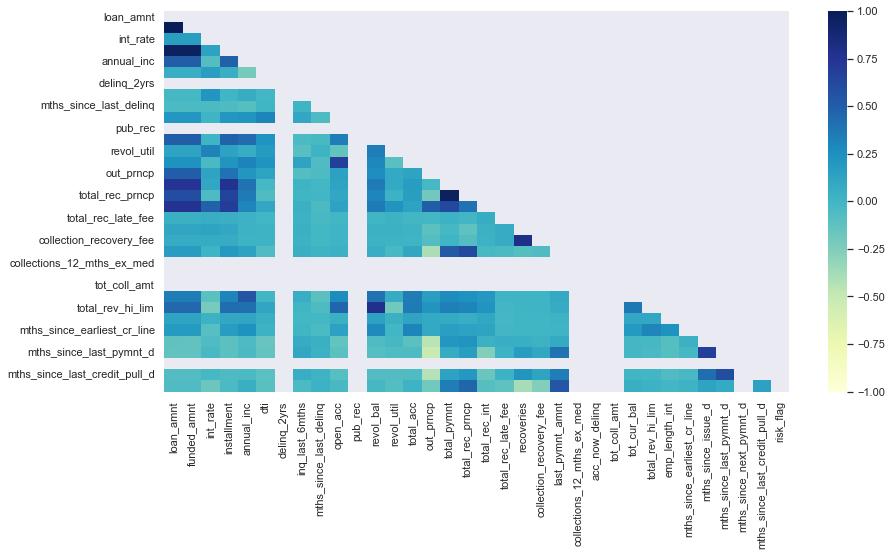

In [62]:
plt.figure(figsize=(14,7))
sns.heatmap(corr_data.corr(), cmap="YlGnBu", mask=np.triu(corr_data.corr()), vmin=-1, vmax=1)
plt.show()

In [63]:
corr_matrix = corr_data.corr().abs()
to_pick_hicorr = corr_matrix.unstack()["risk_flag"].sort_values(kind="quicksort", ascending=False)

In [64]:
to_pick_hicorr

risk_flag                        1.000000
last_pymnt_amnt                  0.539177
total_rec_prncp                  0.462949
recoveries                       0.385262
total_pymnt                      0.340954
collection_recovery_fee          0.258573
out_prncp                        0.189538
int_rate                         0.171876
mths_since_last_credit_pull_d    0.142342
mths_since_issue_d               0.132417
total_rec_late_fee               0.120098
dti                              0.096890
total_rec_int                    0.078826
mths_since_last_pymnt_d          0.078193
revol_util                       0.074960
funded_amnt                      0.060095
loan_amnt                        0.059700
annual_inc                       0.053587
tot_cur_bal                      0.049171
installment                      0.041892
inq_last_6mths                   0.041011
total_rev_hi_lim                 0.031023
mths_since_last_delinq           0.030820
open_acc                         0

In [65]:
num_select = to_pick_hicorr[to_pick_hicorr > 0.3].index.tolist()
num_select.remove("risk_flag")

In [66]:
num_select

['last_pymnt_amnt', 'total_rec_prncp', 'recoveries', 'total_pymnt']

### Categorical

In [67]:
cat_col = corr_data.select_dtypes(include='object').columns.tolist()

In [68]:
label = LabelEncoder()
data_encoded = pd.DataFrame() 

for i in cat_col :
    data_encoded[i]=label.fit_transform(corr_data[i])

In [69]:
data_encoded["risk_flag"] = corr_data["risk_flag"].reset_index(drop=True)

In [70]:
data_encoded.head()

,term,grade,home_ownership,verification_status,pymnt_plan,purpose,initial_list_status,risk_flag
0,0,1,1,0,0,1,1,0
1,1,4,4,1,0,2,1,2
2,0,2,1,2,0,2,0,3
3,0,0,1,2,0,1,0,0
4,0,1,4,2,0,1,0,2


In [71]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    chi2 = stats.chi2_contingency(crosstab)[0]
    n = np.sum(crosstab)
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def cramers_results() :
    rows= []
    for var1 in data_encoded:
        col = []
        for var2 in data_encoded :
            cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
            col.append(round(cramers,2))
        rows.append(col)
    results = np.array(rows)
    return results

cramers_df = pd.DataFrame(cramers_results(), columns = data_encoded.columns, index =data_encoded.columns)

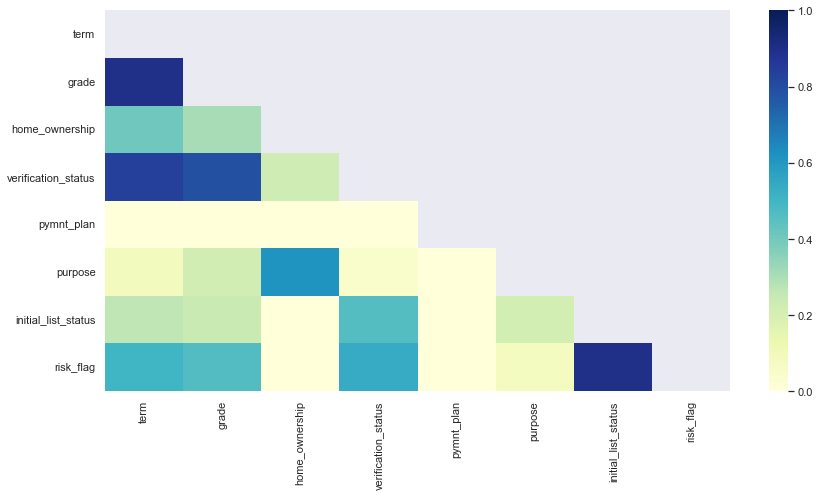

In [72]:
plt.figure(figsize=(14,7))
sns.heatmap(cramers_df.corr(method="spearman"), cmap="YlGnBu", mask=np.triu(cramers_df.corr(method="spearman")), vmin=0, vmax=1)
plt.show()

In [73]:
corr_matrix = cramers_df.corr(method="spearman").abs()
to_pick_hicorr = corr_matrix.unstack()["risk_flag"].sort_values(kind="quicksort", ascending=False)

In [74]:
to_pick_hicorr

risk_flag              1.000000
initial_list_status    0.898220
verification_status    0.538932
term                   0.500000
grade                  0.467074
home_ownership         0.179644
pymnt_plan             0.096225
purpose                0.076621
dtype: float64

In [75]:
cat_select = to_pick_hicorr[to_pick_hicorr >= 0.5].index.tolist()
cat_select.remove("risk_flag")

In [76]:
cat_select

['initial_list_status', 'verification_status', 'term']

In [77]:
X_train = X_train[num_select + cat_select]
X_valid = X_valid[num_select + cat_select]
X_test = X_test[num_select + cat_select]

## Data Prep

### PCA

In [78]:
pca_df = X_train.copy()

In [79]:
ohe = pd.get_dummies(pca_df[cat_select], drop_first=True)

In [80]:
transformer_std = StandardScaler()
pca_df[num_select] = transformer_std.fit_transform(pca_df[num_select])

In [81]:
pca_df = pd.concat([pca_df[num_select], ohe], axis=1)

In [82]:
pca = PCA(n_components = None)
graph_pca = pca.fit_transform(pca_df)

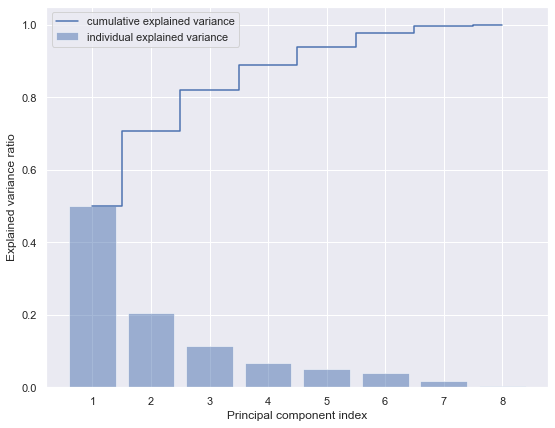

In [83]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

ax, fig = plt.subplots(1,1,figsize=(9, 7))
# Plot explained variances.
plt.bar(range(1, pca_df.shape[1]+1), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, pca_df.shape[1]+1), cum_var_exp, where='mid',
        label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [ ]:
X_valid_join = pd.concat([X_valid, y_valid], axis=1).dropna(axis=0, how="any")
X_valid, y_valid = X_valid_join.drop(["risk_flag"], axis=1), X_valid_join["risk_flag"]

### Pipeline

In [130]:
transformer_std = StandardScaler()
transformer_ohe = OneHotEncoder(drop="first")
pca = PCA(n_components=0.9)
oversample = SMOTETomek(random_state = 42, n_jobs= -1)

preprocessor = ColumnTransformer(
    transformers=[
            ('num', transformer_std, num_select),
            ('cat', transformer_ohe, cat_select)
        ]
    )

clf_random_forest = Pipeline(
    steps=[
            ('preprocessor', preprocessor),
            ('smote', oversample),
            ('pca', pca),
            ('classifier', RandomForestClassifier(random_state=42, n_jobs= -1))
        ]
    )

In [146]:
clf_random_forest.fit(X_valid, y_valid)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['last_pymnt_amnt',
                                                   'total_rec_prncp',
                                                   'recoveries',
                                                   'total_pymnt']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['initial_list_status',
                                                   'verification_status',
                                                   'term'])])),
                ('smote', SMOTETomek(n_jobs=-1, random_state=42)),
                ('pca', PCA(n_components=0.9)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [147]:
val_result = clf_random_forest.predict(X_valid)

In [153]:
print(classification_report(list(y_valid), val_result, target_names=["Bad", "Fair", "Good", "Excellent"]))

              precision    recall  f1-score   support

         Bad       0.96      0.97      0.97      9296
        Fair       0.60      0.97      0.75      1606
        Good       0.99      0.97      0.98     45298
   Excellent       0.99      0.99      0.99     37057

    accuracy                           0.98     93257
   macro avg       0.89      0.97      0.92     93257
weighted avg       0.98      0.98      0.98     93257



In [148]:
f1 = f1_score(list(y_valid), val_result, average="weighted")
print(f1 * 100)

97.75240804558614


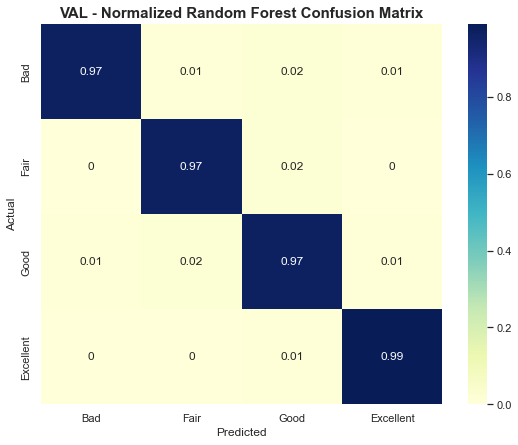

In [139]:
cm = confusion_matrix(list(y_valid), val_result)
cm_norm = np.round(cm / np.sum(cm, axis=1).reshape(-1,1), 2)
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm, 
    cmap="YlGnBu", 
    annot=True,
    xticklabels=["Bad", "Fair", "Good", "Excellent"],
    yticklabels=["Bad", "Fair", "Good", "Excellent"]
)
plt.title("VAL - Normalized Random Forest Confusion Matrix",
    loc="center",
    fontweight="bold",
    size=15
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()